# Grids in PorePy

In this tutorial we investigate the PorePy grids, and explain how to access information stored in the grid. 

## Basic grid construction

The simplest grids are Cartesian. PorePy can create Cartesian grids in 1d, 2d, and 3d. 
There are 0d point grids as well, which are mainly used in the context of intersecting fractures. 
A 2d Cartesian grid can be created as follows:

In [1]:
import numpy as np
import porepy as pp

nx = np.array([3, 2])
g = pp.CartGrid(nx)

The resulting cells will be of unit size, thus the grid covers the domain $[0, 3]\times [0,2]$. 
To specify the domain size, we need to pass a second argument

In [2]:
phys_dims = np.array([10, 10])
g_2 = pp.CartGrid(nx, phys_dims)

Once instantiated, the grids have both node coordinates and topological information that we can access and work with. 
The former will be presented below, and the latter is shown in a separate tutorial. 

To check the grid size, several attributes are provided:

In [3]:
# Number of cells,
print(g.num_cells)

# number of faces,
print(g.num_faces)

# and number of nodes
print(g.num_nodes)

# The grid's dimension is obtained as follows
print(g.dim)

6
17
12
2


We can also print a summary of the grid's properties:

In [4]:
print(g)

Cartesian grid in 2 dimensions.
Number of cells 6
Number of faces 17
Number of nodes 12



The node coordinates are stored as 

In [5]:
g.nodes

array([[0., 1., 2., 3., 0., 1., 2., 3., 0., 1., 2., 3.],
       [0., 0., 0., 0., 1., 1., 1., 1., 2., 2., 2., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

and

In [6]:
g_2.nodes

array([[ 0.        ,  3.33333333,  6.66666667, 10.        ,  0.        ,
         3.33333333,  6.66666667, 10.        ,  0.        ,  3.33333333,
         6.66666667, 10.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  5.        ,
         5.        ,  5.        ,  5.        , 10.        , 10.        ,
        10.        , 10.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

As expected, the second grid covers a larger area.

We also see that even though the grids are 2d, the nodes have three coordinates. 
This is general, all geometric quantities in `PorePy` have three dimensions, even if they represent objects that are genuinely lower-dimensional. 
The reason is that for fractured media, we will often work with grids on fracture surfaces that are embedded in 3d domains, and treating this as special cases throughout the code turned out to be overly cumbersome. 
Also note that the third dimension was introduced automatically, so users need not worry about this. 

# Geometric quantities

To compute additional geometric quantities, grids come with the method `compute_geometry()` that will add attributes `cell_centers`, `face_centers` and `face_normals`:

In [7]:
g.compute_geometry()
print(g.cell_centers)

[[0.5 1.5 2.5 0.5 1.5 2.5]
 [0.5 0.5 0.5 1.5 1.5 1.5]
 [0.  0.  0.  0.  0.  0. ]]


And similar for face information. 
It is of course possible to set the geometric quantities manually. 
Be aware that a subsequent call to `compute_geometry()` will overwrite this information.

It may, for some users, be useful to consider grids with a Cartesian topology, but with perturbed geometry. 
This is achieved by perturbing the nodes, and then (re)-computing geometry:

In [8]:
g_2.compute_geometry()
print(g_2.cell_centers)
g_2.nodes[:2] = g_2.nodes[:2] + np.random.random((g_2.nodes[:2].shape))
g_2.compute_geometry()
print(g_2.cell_centers)

[[1.66666667 5.         8.33333333 1.66666667 5.         8.33333333]
 [2.5        2.5        2.5        7.5        7.5        7.5       ]
 [0.         0.         0.         0.         0.         0.        ]]
[[2.34506033 5.53186086 8.67887581 2.28081847 5.67871799 8.87013948]
 [3.11299461 3.20712804 2.84864565 8.31641255 8.29186561 7.92618944]
 [0.         0.         0.         0.         0.         0.        ]]


When perturbing nodes, make sure to limit the distortion so that the grid topology still is valid; if not, all kinds of problems may arise.

## Visualization

`PorePy` provides two ways of visualizing the grid, matplotlib, and vtk/ParaView. Matplotlib visualization is done by

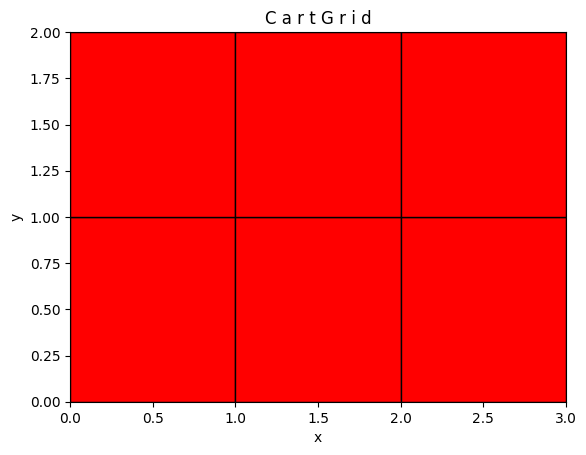

In [9]:
pp.plot_grid(g, plot_2d=True)

The matplotlib interface is most useful for quick visualization, e.g. during debugging, and other visualization tools are recommended to be used otherwise. 

For showing information about cell numbers, node numbers, face numbers and face normals, we can assign values to the parameters `info` and `alpha` in `pp.plot_grid()`.
The parameter `info` decides which extra information is shown and the value of `alpha` determines the transparency of the grid.


For instance, the lines of code below will plot a grid where we can see cell-, face- and node numbers, in addition to having all the cells colored with separate colors:

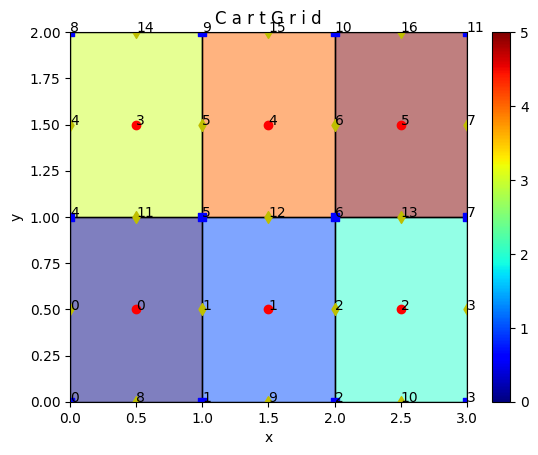

In [10]:
cell_id = np.arange(g.num_cells)
pp.plot_grid(
    g,
    cell_value=cell_id,
    info="cfn",
    alpha=0.5,
    figsize=(10, 8),
    plot_2d=True,
)

For further information, see the documentation of `plot_grid`.

The second visualization option dumps the grid to a vtu file:

In [11]:
e = pp.Exporter(g, "grid")
e.write_vtu()

This file can then be accessed by e.g. [ParaView](https://www.paraview.org/). 
There is an entire tutorial related to exporting of data, so for a thorough walk-through of this we refer to the [exporter tutorial](./exporter.ipynb).

# Simplex grids


In addition to constructor methods for Cartesian grids in 2d and 3d, PorePy supoorts simplex grids in both 2d and 3d. 
The simplex grids can be specified either by point coordinates and a cell-node map (e.g. a Delaunay triangulation), or simply by the node coordinates. 
In the latter case, the Delaunay triangulation (or the 3d equivalent) will be used to construct the grid. 
The representation of grid geometry and topology is the same for Cartesian and simplex grids. 
This allows for setting up simulations, defining discretization methods etc., in ways that are agnostic to the problem dimension.

As an example, we make a triangle grid using the nodes of g, distorting the y coordinate of the two central nodes slightly: 


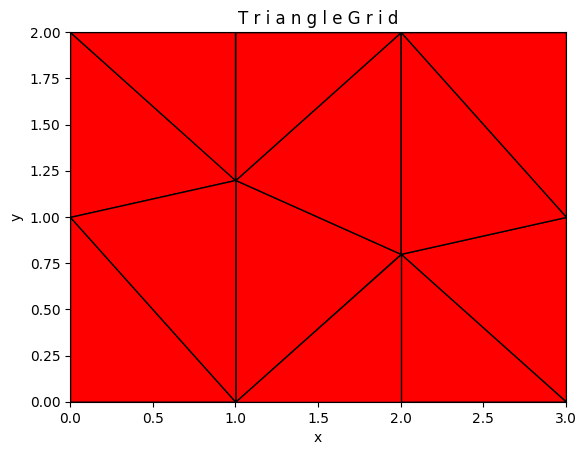

In [12]:
nodes = g.nodes[:2]
nodes[1, 5:7] = np.array([1.2, 0.8])
g = pp.TriangleGrid(nodes)
g.compute_geometry()
pp.plot_grid(g, plot_2d=True)

A structured triangular grid (squares divided into two) is also provided:

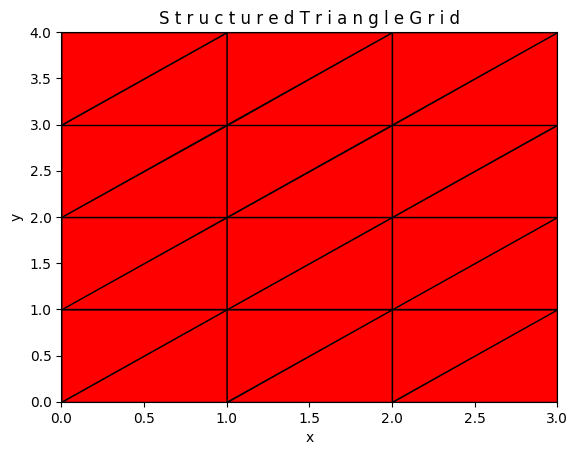

In [13]:
g = pp.StructuredTriangleGrid(np.array([3, 4]))
g.compute_geometry()
pp.plot_grid(
    g,
    plot_2d=True,
)

# Import of grids from external meshing tools

Currently, PorePy supports import of grids from Gmsh. 
This is mostly used for fractured domains as described in the [mixed-dimensional grid tutorial](./mixed_dimensional_grids.ipynb).

The grid structure in PorePy is fairly general, and can support a much wider class of grids than those currently implemented. 
To import a new type of grid, all that is needed is to construct the face-node and cell-face maps, together with importing the node coordinates. 
Remaining geometric attributes can then be calculated by the `compute_geometry()` function. 



# What have we explored
We have seen that PorePy provides convenient construction of Cartesian and simplex grids in 2d and 3d. The geometric information relevant to a grid (node coordinates, cell and face centers, cell volumes, face areas and face normal vectors) are computed by the method `compute_geometry()`. All coordinates are three-dimensional fields, even if the grid is of a lower dimension. Small grids can be visualized by the method `pp.plot_grid()`; for larger grids, it is advisable to export the grid to ParaView as demonstrated in the [exporter tutorial](./exporter.ipynb).